In [1]:
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error
from rasterio.plot import reshape_as_image
from tqdm import tqdm

import numpy as np
import progressbar
import pandas as pd
import xarray as xr

from data.satellite import SatelliteData, BANDS_WITH_NO_AIR, Normalization

%matplotlib inline 

Band info for reference: https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/

## Load test data

In [2]:
kwargs = {
    "data_root": "../Arizona-processed4",
    "seq_len": 60,
    "no_randomization": True,
    "bands_to_keep": BANDS_WITH_NO_AIR
}

test_data = SatelliteData(train=False, **kwargs, normalization=Normalization.Z)
test_data_unnormalized = SatelliteData(train=False, normalization=Normalization.SKIP, **kwargs)

Using: 556 for testing
Using: 556 for testing


In [3]:
loaded_test_data = np.array([t.numpy() for t in tqdm(test_data)])

100%|██████████| 556/556 [00:48<00:00, 11.51it/s]


In [4]:
def check_data(tile, month=7):
    tile_np = tile.numpy()
    print(f"Mean: {tile_np.mean()}\nMax: {tile_np.max()}\nMin: {tile_np.min()}\nSTD: {tile_np.std()}")
    
    # Visualize image as test
    img = test_data.for_viewing(tile_np[month])
    
    plt.imshow(reshape_as_image(img))
    plt.show()

Mean: -0.6003812291169063
Max: 25.82455662761002
Min: -4.709863473706446
STD: 1.3554785279990569


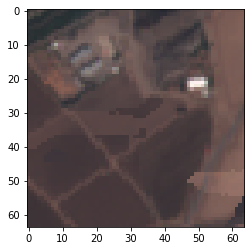

In [5]:
check_data(test_data[10])

## Baseline - utility code

In [6]:
def compute_mse(loaded_test_data, forecast_months=7, baseline_type="all_years", unnormalize=False):
    """
    Computes mean squared error
    """
    total_mse_per_bands = 0

    for test_inst in tqdm(loaded_test_data):
        
        if unnormalize:
            test_inst = test_data.unnormalize(test_inst)
        
        s = test_inst.shape
        test_inst_by_year = test_inst.reshape(-1, 12, s[1], s[2], s[3])

        # Set y to be latest 7 months
        Y_true = test_inst_by_year[-1][-forecast_months:]
        
        if baseline_type == "all_years":
            # Set y pred to be average of all past year's 7 months
            Y_pred = test_inst_by_year[:-1].mean(axis=0)[-forecast_months:]
        elif baseline_type == "last_year":
            # Set y pred to be last year's 7 months
            Y_pred = test_inst_by_year[-2][-forecast_months:]
        elif baseline_type == "last_month":
            Y_pred = test_inst_by_year[-1][-(forecast_months+1)]
        else:
            raise ValueError("baseline_type must be 'all_years', 'last_year', or 'last_month'")
        
        # Calculate mean squared loss per band
        total_mse_per_bands += ((Y_true - Y_pred)**2).mean(axis=(0,-2,-1))
        
    mean_mse_per_bands = total_mse_per_bands / len(loaded_test_data)
        
    return mean_mse_per_bands

In [7]:
def plot_mses(mses, title):
    df = pd.DataFrame(mses)
    df = df.set_index(pd.Index(test_data.bands_to_keep))
    df.plot(kind='bar', figsize=(15,5), 
            title=title,
           xlabel="Band",
           ylabel="MSE");

100%|██████████| 556/556 [00:02<00:00, 199.58it/s]


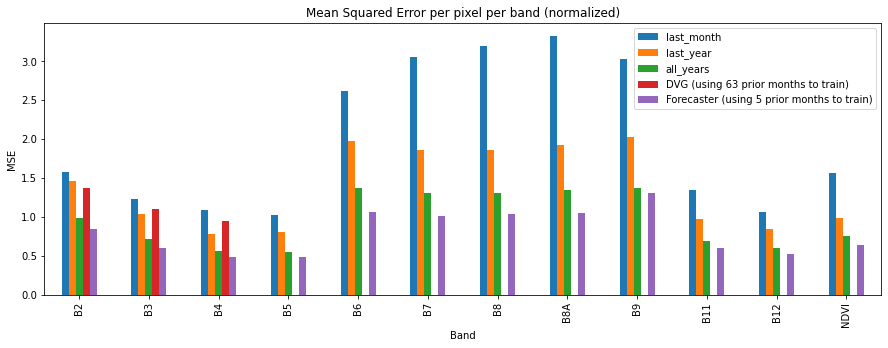

In [8]:
mses = {
    k: compute_mse(loaded_test_data, baseline_type=k)
    for k in ["last_month", "last_year", "all_years"]
}

mses["DVG (using 63 prior months to train)"] = [1.3702908, 1.1102128, 0.94570667] + [0 for i in range(9)]
mses["Forecaster (using 5 prior months to train)"] = [0.84178023, 0.60160971, 0.48618681, 0.48346133, 1.05982456,
       1.01759255, 1.04585694, 1.05148563, 1.31319203, 0.60696182,
       0.52989607, 0.63550722]

plot_mses(mses, title="Mean Squared Error per pixel per band (normalized)")

100%|██████████| 556/556 [00:08<00:00, 68.51it/s]


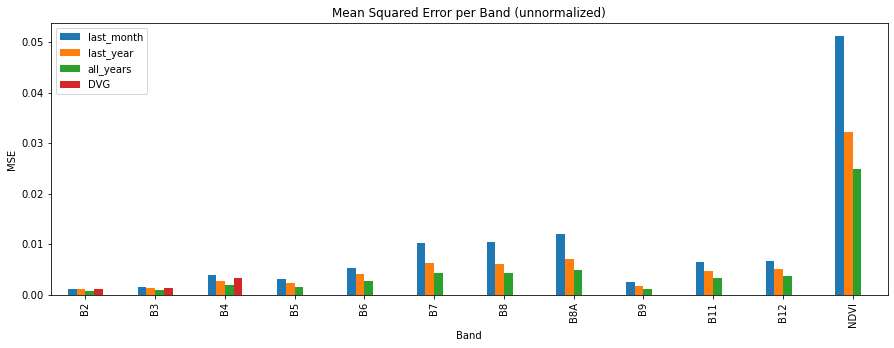

In [11]:
mses = {
    k: compute_mse(loaded_test_data, baseline_type=k, unnormalize=True)
    for k in ["last_month", "last_year", "all_years"]
}

mses["DVG"] = [0.00107829, 0.00145277, 0.0034245] + [0 for i in range(9)]
#mses["Forecaster"] = 

plot_mses(mses, title="Mean Squared Error per Band (unnormalized)")